In [7]:
import pandas as pd
import json
import os
import spotipy
import scipy.stats as stats
from spotipy.oauth2 import SpotifyOAuth
import matplotlib.pyplot as plt
import numpy as np
from spotipy.oauth2 import SpotifyClientCredentials
import time
import requests
import seaborn as sns


# Set your Spotify API credentials
os.environ["SPOTIPY_CLIENT_ID"] = "ac3a06f88c94438e904e5fb6f4cd19b9"
os.environ["SPOTIPY_CLIENT_SECRET"] = "da619d1d04794e4cab338a691146fbbd"

# Create a Spotify client
sp = spotipy.Spotify(client_credentials_manager=SpotifyClientCredentials())

# Project Topic

---

### Explanation:

<p>
Every song stored in the spotify database contain a set of audio-features that define certain aspects of a track. There are certain concrete easily measurable features like tempo, key , mode ... . There are also other features that are derived by the spotify team like danceability, valence(positivity of a song), energy ... . For my project I want to be able to predict a particular audio feature by a combination of other audio features in the database. For example if I am given the danceability, acousticness, and liveness features associated with a certain track, I want to predict the Energy feature. By the end of my EDA I will have a better idea of which target and predictor features to use in my model. Given that I am going to be using continuous ordinal features for the input and output of my model this is a regression problem.

### Goal:
<p>
For this project I hope to learn more about the complexities that go into multi-linear regression problems, how to prepare data, and how to select features for such a model. I also hope to explore more about how certain aspects of music and how the different musical choices influence each other.
</p>

---

## Data 

For my training data I am using the Spotify Million Playlist Dataset. The Data is a set of a million different playlists each containing a set of at most 250 tracks created by users of the Spotify platform. I obtained the dataset from aicrowd.com https://www.aicrowd.com/challenges/spotify-million-playlist-dataset-challenge.

The data is divided into 1000 different slice files. Each file contains 1000 playlists. The size of each slice is on average 32 MB. I will most likely not be using all one million playlists because of computational limits of the model and APIs I use to fetch additional features below. The beauty of this dataset is that I can control how many slices I want to use. For this initial stage I am only using 1 slice file, which contains 34421 rows. I'm converting the JSON filetype into a tabulated dataframe. I am only using the playlists to get names of tracks and then I will be grouping the dataframe by track id. I am not keeping track of playlists as I am only using the dataset to find valid TrackIDs in the spotify database and then using the spotify API to find the audio-features of each track. The features I am using in the initial dataset are:

- Artist (String)
- Track (String)
- Track ID - The unique identifier for the track in the spotify database (string)
- Artist ID - The unique identifier for the track's artist in the spotify database (String)

I will be using API's later in my data curation below to fetch more unique features for each track. I will be extending the features to include:

- Danceability - Spotify metric describing danceability of track (FLoat)
- Valence - Spotify metric describing the positivity or happiness of a track (Float)
- Energy - Spotify metric measuring intensity and activity of a track (Float)
- Instrumentalness - Spotify metric measuring likelihood of track being an instrumental (Float)
- Liveness - Spotify metric recording the likelihood of a audience in the track (Float)
- Speechiness- Spotify metric recording the amount of spoken word in a track (FLoat)
- Tempo - :The BPM (beats per minute) of a track (Int)
- Key - : Represents the set of musical keys a track falls into (Int)
- Mode - : Represents a major (0) or minor (1) mode (Int)
- Duration- : The length of a song in seconds (Int)

---

The code below downloads the specified n number of slices, pulls each track and the first 5 features of the track specified above, and converts the JSON data into a dataframe. Each item is unique based on it's Track ID.

## Bonus:

I believe that this project does qualify for bonus credit. I curated this dataset from scratch using a complicated API. I did not follow a guide online that came along with this dataset. I am taking the risk that things might not work out and I will have to spend extra effort to get accurate results.

In [34]:

tracks = pd.DataFrame()

n = 2  # Change this to the number of files you have
for i in range(0, n*1000, 1000):
    filename = f"spotify_million_playlist_dataset/data/mpd.slice.{i}-{i+999}.json"
    
    with open(filename, "r") as f:
        data = json.load(f)

    update_tracks = []
    playlists = pd.json_normalize(data, record_path="playlists")
    
    for _, playlist in playlists.iterrows():
        for track in playlist["tracks"]:
            track["pid"] = playlist["pid"]
            update_tracks.append(track)

    tracks = tracks.append(pd.DataFrame(update_tracks), ignore_index=True)

/tmp/ipykernel_7224/855619689.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tracks = tracks.append(pd.DataFrame(update_tracks), ignore_index=True)
/tmp/ipykernel_7224/855619689.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tracks = tracks.append(pd.DataFrame(update_tracks), ignore_index=True)


In [35]:

data = pd.DataFrame({"artist" : tracks["artist_name"], 
                            "artist_id": tracks["artist_uri"].apply(lambda x : x.split("spotify:artist:")[1]),
                            "track" : tracks["track_name"],
                            "track_id": tracks["track_uri"].apply(lambda x : x.split("spotify:track:")[1]),
                            "playlist id": tracks["pid"]})

data = data.drop_duplicates(subset="track_id", keep="first")

--- 

We now have a base dataframe to build off of.  I will need some way to collect unique features of each track. The functions defined below use the Spotipy library to accomplish this. The Spotipy library methods send an API call to different Spotify Developer API endpoints returning the popularity metric and unique audio feature values for each track in the dataframe. These are the same features that spotify utilize in their recommendation systems. The process of fetching features with API's is not related to the class so I will spare the details.



In [36]:
import time
import requests

def get_features(func_type, feature_type, ids):
    def fetch_features(batch_ids, max_retries=3, backoff_factor=2):
        retries = 0
        while retries <= max_retries:
            try:
                response = func_type(batch_ids)
                return response
            except requests.exceptions.RequestException as e:
                if retries < max_retries:
                    sleep_time = backoff_factor * (2 ** retries)
                    time.sleep(sleep_time)
                    retries += 1
                else:
                    raise e

    features = {}
    if feature_type == "audio_features":
        for i in range(0, len(ids), 50):
            batch_ids = ids[i:i + 50]
            batch_features = fetch_features(batch_ids)

            for feature in batch_features:
                if feature is not None:
                    features[feature['id']] = feature
    else:
        for i in range(0, len(ids), 50):
            batch_ids = ids[i:i + 50]
            batch_features = fetch_features(batch_ids)

            for feature in batch_features[feature_type]:
                if feature is not None:
                    features[feature['id']] = feature

    return features

--- 

In the code below I am calling my get_features method to fetch the audio features. This will return a python dictionary of track Id (key) and the audio features (values) for each track in my data. I then convert the audio features to a dataframe.

In [38]:
#Get the audio features of each track
track_ids = data["track_id"].drop_duplicates().reset_index(drop=True)

#track_ids = data["Track_ID"].drop_duplicates().reset_index(drop=True)
audio_features = get_features(sp.audio_features, 'audio_features', track_ids)
audio_feature_types = ["acousticness", "danceability", "duration_ms", "energy", "instrumentalness", "key", "liveness", "loudness", "mode", "speechiness", "tempo", "time_signature", "valence"]
rows = []
for track_id in track_ids:
    new_row = {"track_id": track_id}
    for feature in audio_feature_types:
        new_row[f"{feature}"] =  audio_features[track_id][feature]
    rows.append(new_row)

audio_features_df = pd.DataFrame(rows)



Now we have two intermediate dataframes that hold the the popularity metrics and audio features. We can move onto merging and cleaning the data in the dataframe.

---


# Data Cleaning

In my get_features method, if for some reason a track ID I used to fetch a feature does not exist in the spotify database then that track will be rejected and will not be included in the dataframes holding the features.  This presents a problem when I merge them back into my main dataframe. Specifically there will be certain tracks in the main dataframe that do not exist in the features dataframes creating Null values. I have printed the rows that match this case containing null values below. We will just drop any tracks with null values from the dataframe and will not use them in our model. Since there are so many songs in each playlist dropping a few songs won't make much of a difference.

In [40]:
data = data.merge(audio_features_df, how="left", on="track_id")

In [41]:
null_rows = data[data.isnull().any(axis=1)]
null_rows

,artist,artist_id,track,track_id,playlist id,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence


In [42]:
data = data.dropna()
null_rows = data[data.isnull().any(axis=1)]
null_rows

,artist,artist_id,track,track_id,playlist id,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence


In [43]:
data.to_csv("spotify_million_playlist_dataset/transformed_data/data.csv")

In [2]:
data = pd.read_csv("spotify_million_playlist_dataset/transformed_data/data.csv")

## EDA

/tmp/ipykernel_7224/3897049283.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = data.corr()


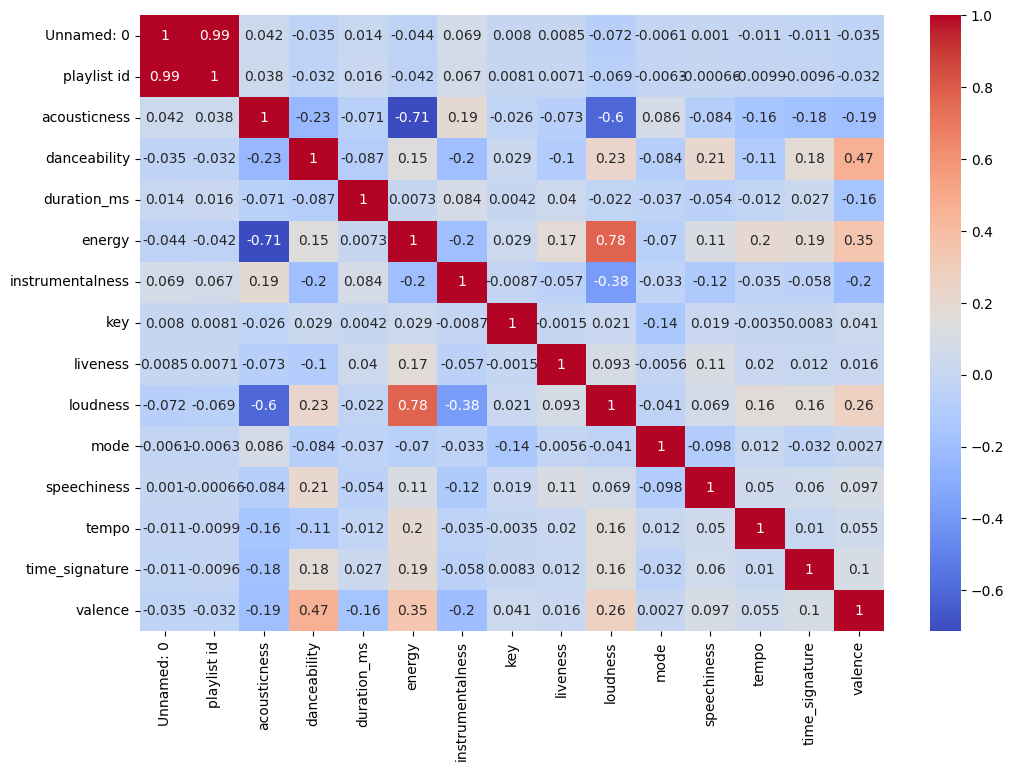

In [45]:
corr_matrix = data.corr()


plt.figure(figsize=(12, 8))

sb.heatmap(corr_matrix, annot=True, cmap='coolwarm')

plt.xticks(rotation=90)
plt.yticks(rotation=0)

plt.show()

From the correlation matrix we can detect there are only a few features with a high level of correlation to others. Some good potential target features would include loudness, energy, danceability, or acousticness. Below I will list the dependent variable and the set of the best potential predictors.

valence ~ [danceability, energy]

loudness ~ [acousticness, energy, instrumentalness]

energy ~ [acousticness, loudness]

acousticness ~ [loudness, energy]

Now lets make some scatter plots to verify the correlation and check for non-linear correlation as well.

Text(0.5, 0, 'Energy')

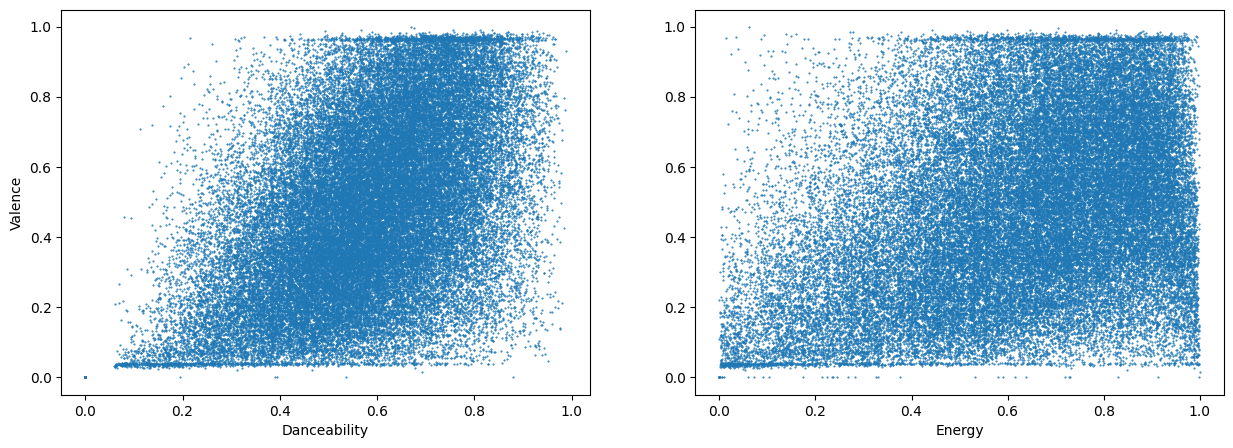

In [47]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

axes[0].plot(data['danceability'], data['valence'], 'o', markersize=.5)  # Replace with your data and plotting code
axes[0].set_xlabel('Danceability')
axes[0].set_ylabel('Valence')

axes[1].plot(data['energy'], data['valence'], 'o', markersize=.5)  # Replace with your data and plotting code
axes[1].set_xlabel('Energy')


The relationship between these features do seem to be somewhat linear as the correlation matrix suggests. I would worry about Valence ~ Energy. There does seem to be higher valence values as Energy increases, but it does not seem to be too strong.

Text(0.5, 0, 'Instrumentalness')

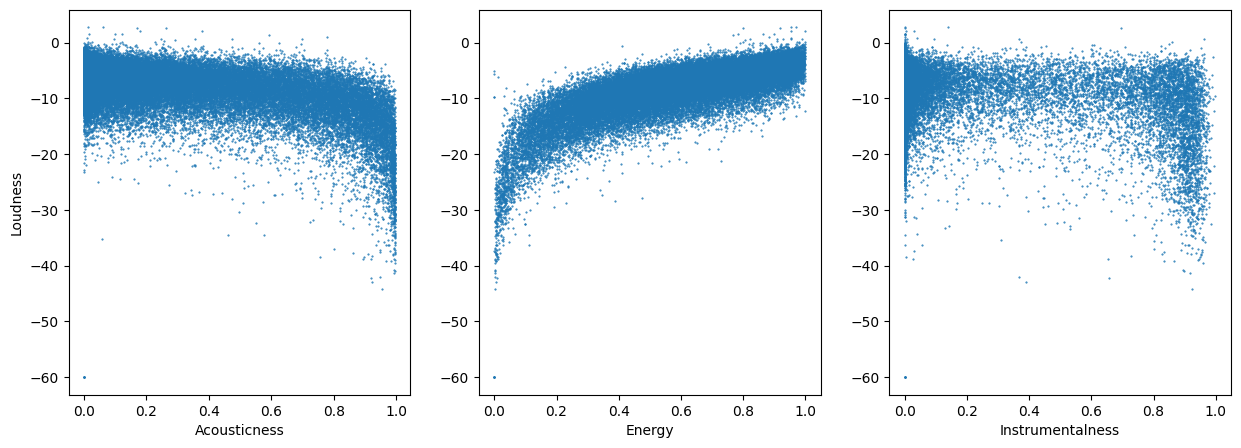

In [48]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))

axes[0].plot(data['acousticness'], data['loudness'], 'o', markersize=.5)  # Replace with your data and plotting code
axes[0].set_xlabel('Acousticness')
axes[0].set_ylabel('Loudness')

axes[1].plot(data['energy'], data['loudness'], 'o', markersize=.5)  # Replace with your data and plotting code
axes[1].set_xlabel('Energy')

axes[2].plot(data['instrumentalness'], data['loudness'], 'o', markersize=.5)  # Replace with your data and plotting code
axes[2].set_xlabel('Instrumentalness')


All of these features do share correlation with Loudness. Acousticness and Energy obviously seem the most correlated. Instrumentalness doesn't look as correlated when compared to the other two, but I think there is some amount of correlation that may be significant especially when using the other two more correlated features.

I do really like what I am seeing here, but Loudness does not seem like an interesting audio-feature to predict in my opinion. Let's take a look at one more possible predictor, Energy.

Text(0.5, 0, 'Loudness')

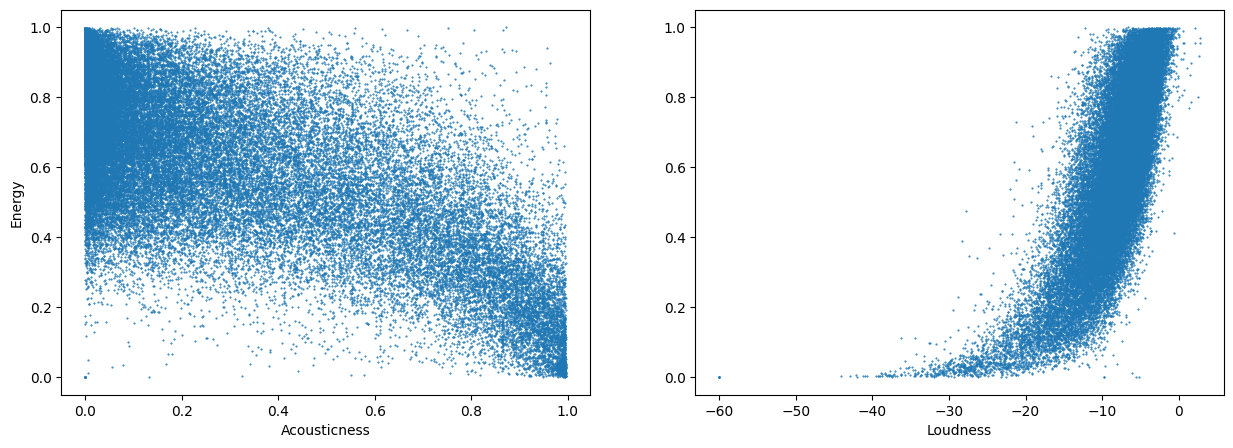

In [88]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

axes[0].plot(data['acousticness'], data['energy'], 'o', markersize=.5) 
axes[0].set_xlabel('Acousticness')
axes[0].set_ylabel('Energy')

axes[1].plot(data['loudness'], data['energy'], 'o', markersize=.5)
axes[1].set_xlabel('Loudness')

There does seem to be a negative correlation between Energy and acousticness and a very strong positive correlation between Energy and loudness. Both of the curves of this model look more polynomial than linear. This would be a great motivation to try a polynomial regression model and compare it to a linear model.

I think Energy would make a great target feature in my model. In my opinion it is a more interesting audio-feature when compared to loudness. Energy also has the two features with the highest correlation values in the whole dataset.

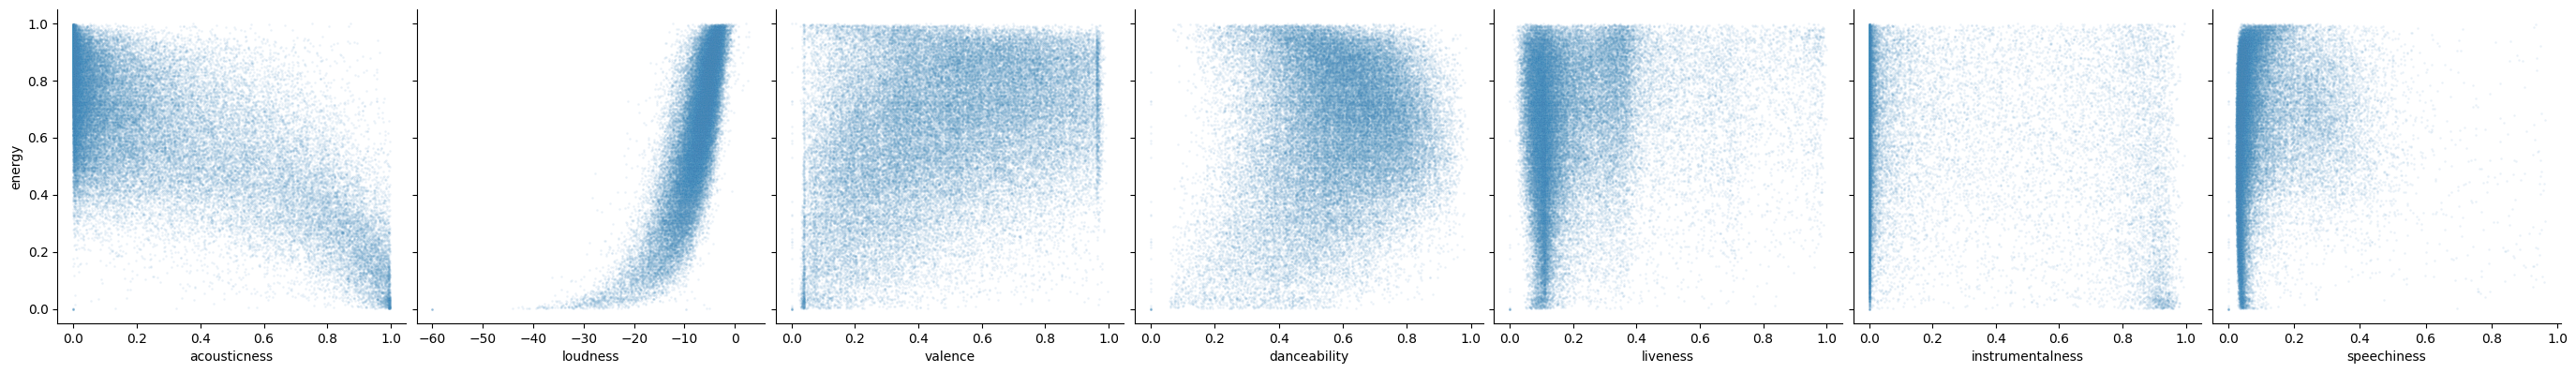

In [49]:
features = ['acousticness', 'loudness', 'valence', 'danceability', 'liveness', 'instrumentalness', 'speechiness']
pairplot = sns.pairplot(data=data, x_vars=features, y_vars=['energy'], plot_kws={'s': 3, 'alpha': 0.1}, height=4)

Here are all of the possible predictors compared to Energy

## EDA Conclusions

After interpreting the data I would say the best target feature selection would be Energy. Energy  has the top two most correlated features with acousticness and loudness. There are a couple other correlations that might be helpful as well such as valence and instrumentalness, shown above in the pairplot above, each of which shares a correlation with energy at .35 and -.2 respectively. 

I am going to have to be careful of multicolinearity in my model because acousticness and loudness have a correlation of -.6. I will need to be aware of and evaluate this relationship in my model. 

The data is now clean and I have determined my desired target variable. It is now time to create a model 



## Model

I decided to simply split my dataframe in half to create my testing and training data. If my data was limited I would worry about this approach and use random sampling or something similar. However I have access to millions of tracks so it should not be a problem. 

In [57]:
# calculate the halfway point of the dataframe
halfway_point = len(data) // 2

# split the dataframe in half
train_data = data.iloc[:halfway_point]
test_data = data.iloc[halfway_point:]

# reset the index for both dataframes
train_data.reset_index(drop=True, inplace=True)
test_data.reset_index(drop=True, inplace=True)

#### VIF

Because there is risk of multicolinearity determined from the EDA above I decided to use another metric in order to determine the correlation of independent variables inside of my model. I decided to use the VIF or variance inflation factor. VIF quantifies the inflation of the regression coefficients due to multicolinearity. If a feature has a VIF of 10 or above, this signifies that feature introduces severe multicolinearity to the model. 

In [58]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from patsy import dmatrices

def calculate_vif(formula, data):
    # Extract the independent variables from the data
    y, X = dmatrices(formula, data=data, return_type='dataframe')

    # Calculate VIF for each independent variable
    vif = pd.DataFrame()
    vif['VIF Factor'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    vif['Features'] = X.columns

    return vif


#### Linear Model:

Below I implemented a simple multi-linear regression model. I used forward selection to find the features that best fit the model. 

In [94]:
best_r_squared = 0
best_formula = 'energy ~ 1'

# list of possible features to add
features = ['acousticness', 'loudness', 'valence', 'danceability', 'liveness', 'instrumentalness', 'speechiness']

# keep looping until we find the best combination of features
while len(features) > 0:

    # keep track of the best feature from this loop
    max_r_squared = 0
    best_candidate = None

    # try adding each feature to the model and see which one has the highest r-squared value
    for feature in features:
        candidate_formula = f'{best_formula} + {feature}'
        candidate_model = smf.ols(formula=candidate_formula, data=train_data).fit()

        if candidate_model.rsquared_adj > max_r_squared:
            max_r_squared = candidate_model.rsquared_adj
            best_candidate = feature

    # if adding the feature to our model increased the r-squared value, add the feature to our formula
    if max_r_squared > best_r_squared:
        best_r_squared = max_r_squared
        best_formula = f'{best_formula} + {best_candidate}'
        features.remove(best_candidate)
    else:
        break

# fit the final model to the test data
linear_model = smf.ols(formula=best_formula, data=test_data).fit()
linear_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 energy   R-squared:                       0.765
Model:                            OLS   Adj. R-squared:                  0.765
Method:                 Least Squares   F-statistic:                 1.345e+04
Date:                Mon, 08 May 2023   Prob (F-statistic):               0.00
Time:                        04:00:45   Log-Likelihood:                 21340.
No. Observations:               28942   AIC:                        -4.266e+04
Df Residuals:                   28934   BIC:                        -4.260e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept            0.9122      0.003    274.358      0.000       0.906       0.919
loudness             0.0294      0.000    145.033      0.000       0.029       0.030
acousticness        -0.2958      0.003   -106.152      0.000      -0.301      -0.290
valence              0.1902      0.003     59.430      0.000       0.184       0.196
danceability        -0.1846      0.005    -38.460      0.000      -0.194      -0.175
instrumentalness     0.1167      0.003     39.595      0.000       0.111       0.122
liveness             0.1083      0.004     27.425      0.000       0.101       0.116
speechiness          0.1364      0.007     19.068      0.000       0.122       0.150
==============================================================================
Omnibus:                      590.787   Durbin-Watson:                   1.635
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1301.202
Skew:                          -0.001   Prob(JB):                    2.80e-283
Kurtosis:                       4.039   Cond. No.                         100.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [23]:
calculate_vif(best_formula, train_data) 

,VIF Factor,Features
0,25.296611,Intercept
1,1.734398,loudness
2,1.576069,acousticness
3,1.261946,valence
4,1.334784,danceability
5,1.169417,instrumentalness
6,1.051869,liveness
7,1.076086,speechiness


#### Interactions:

Below I developed an exausted method to find statistically significant interactions. This is similar to the method we used in HW 7. This produces way too many coefficients which I discuss I will discuss in the results section.

In [18]:
insig_found = True

interaction_formula = best_formula.replace('1 + ', '')
interaction_formula = interaction_formula.replace(' + ', ' * ')

# keep looping until we find a model where all coefficients are significant
while (insig_found):
    
    insig_found = False
    new_formula = 'energy ~ '

    # fit the model and get the p-values
    new_model = smf.ols(formula = f'{interaction_formula}', data=data).fit()
    pvalues = new_model.pvalues

    # loop through the p-values and look for insignificant coefficients
    for coefficient in pvalues.index:
        if coefficient == 'Intercept':
            continue
        
        if pvalues[coefficient] <= 0.05:
            new_formula = f'{new_formula} + {coefficient}'
        else:
            insig_found = True
    
    interaction_formula = new_formula

# fit the final model to the test data
smf.ols(formula = f'{interaction_formula}', data=data).fit().summary()
    




<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 energy   R-squared:                       0.790
Model:                            OLS   Adj. R-squared:                  0.790
Method:                 Least Squares   F-statistic:                     2245.
Date:                Sun, 07 May 2023   Prob (F-statistic):               0.00
Time:                        23:46:32   Log-Likelihood:                 47830.
No. Observations:               57884   AIC:                        -9.546e+04
Df Residuals:                   57786   BIC:                        -9.458e+04
Df Model:                          97                                         
Covariance Type:            nonrobust                                         
===========================================================================================================================================
                                                                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------------------------------------------
Intercept                                                                   0.6409      0.013     48.114      0.000       0.615       0.667
loudness                                                                    0.0124      0.001     16.103      0.000       0.011       0.014
acousticness                                                               -0.4124      0.022    -18.771      0.000      -0.455      -0.369
valence                                                                     0.7401      0.032     23.326      0.000       0.678       0.802
loudness:valence                                                            0.0279      0.003      8.671      0.000       0.022       0.034
acousticness:valence                                                       -0.2770      0.055     -5.018      0.000      -0.385      -0.169
danceability                                                                0.5396      0.027     19.912      0.000       0.486       0.593
loudness:danceability                                                       0.0697      0.002     28.685      0.000       0.065       0.074
acousticness:danceability                                                  -0.3242      0.051     -6.308      0.000      -0.425      -0.223
loudness:acousticness:danceability                                         -0.0674      0.004    -18.958      0.000      -0.074      -0.060
valence:danceability                                                       -1.1688      0.053    -22.070      0.000      -1.273      -1.065
loudness:valence:danceability                                              -0.0927      0.005    -17.178      0.000      -0.103      -0.082
acousticness:valence:danceability                                           1.0135      0.099     10.196      0.000       0.819       1.208
loudness:acousticness:valence:danceability                                  0.0787      0.006     12.602      0.000       0.066       0.091
instrumentalness                                                            0.2338      0.050      4.708      0.000       0.136       0.331
loudness:instrumentalness                                                   0.0412      0.005      8.280      0.000       0.031       0.051
acousticness:instrumentalness                                              -0.5879      0.085     -6.892      0.000      -0.755      -0.421
loudness:acousticness:instrumentalness                                     -0.0667      0.007    -10.064      0.000      -0.080      -0.054
valence:instrumentalness                                                   -0.6938      0.148     -4.701      0.000      -0.983      -0.405
lou

In [25]:
vif_df = calculate_vif(interaction_formula, train_data)
vif_df

,VIF Factor,Features
0,1128.136686,Intercept
1,109.248704,loudness
2,270.019511,acousticness
3,349.197555,valence
4,401.532217,loudness:valence
...,...,...
93,15263.806464,loudness:acousticness:danceability:liveness:sp...
94,7842.075858,valence:danceability:liveness:speechiness
95,16505.415133,loudness:valence:danceability:liveness:speechi...
96,12663.312822,acousticness:valence:danceability:liveness:spe...


#### Polynomial Regression

Below I have implemented a polynomial regression model that uses features to the power of two. I found this degree to give the best results. This method is less exhaustive then the method I used when making the linear model. I chose this approach because this model uses a more complex formula.

In [96]:
import statsmodels.formula.api as smf

best_r_squared = 0
best_formula = 'energy ~ 1'

# list of possible features to add
features = ['acousticness', 'loudness', 'valence', 'danceability', 'liveness', 'instrumentalness', 'speechiness']

# keep looping until we find the best combination of features
for feature in features:

    # Add the squared term of the feature
    model = smf.ols(formula=f'{best_formula} + {feature} + np.power({feature}, 2)', data=train_data).fit()

    # if the r-squared value from the new model is better, update the best formula
    if model.rsquared_adj > best_r_squared:
        best_r_squared = model.rsquared_adj
        best_formula = f'{best_formula} + {feature} + np.power({feature}, 2)'

# fit the final model to the test data
poly_model = smf.ols(formula=f'{best_formula}', data=test_data).fit()
poly_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 energy   R-squared:                       0.792
Model:                            OLS   Adj. R-squared:                  0.792
Method:                 Least Squares   F-statistic:                     7864.
Date:                Mon, 08 May 2023   Prob (F-statistic):               0.00
Time:                        04:01:58   Log-Likelihood:                 23104.
No. Observations:               28942   AIC:                        -4.618e+04
Df Residuals:                   28927   BIC:                        -4.605e+04
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
=================================================================================================
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Intercept                         0.8603      0.006    134.414      0.000       0.848       0.873
acousticness                     -0.2983      0.008    -38.074      0.000      -0.314      -0.283
np.power(acousticness, 2)         0.0408      0.009      4.488      0.000       0.023       0.059
loudness                          0.0485      0.000    119.838      0.000       0.048       0.049
np.power(loudness, 2)             0.0007   1.31e-05     55.336      0.000       0.001       0.001
valence                           0.1374      0.011     11.963      0.000       0.115       0.160
np.power(valence, 2)              0.0398      0.011      3.664      0.000       0.018       0.061
danceability                      0.3291      0.021     15.680      0.000       0.288       0.370
np.power(danceability, 2)        -0.4301      0.018    -23.366      0.000      -0.466      -0.394
liveness                          0.0945      0.011      8.275      0.000       0.072       0.117
np.power(liveness, 2)             0.0160      0.013      1.190      0.234      -0.010       0.042
instrumentalness                  0.2297      0.012     18.449      0.000       0.205       0.254
np.power(instrumentalness, 2)    -0.1416      0.015     -9.575      0.000      -0.171      -0.113
speechiness                       0.3451      0.016     21.439      0.000       0.314       0.377
np.power(speechiness, 2)         -0.4209      0.030    -13.838      0.000      -0.480      -0.361
==============================================================================
Omnibus:                      448.757   Durbin-Watson:                   1.668
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              878.626
Skew:                          -0.020   Prob(JB):                    1.62e-191
Kurtosis:                       3.853   Cond. No.                     8.50e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 8.5e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [35]:
vif_df = calculate_vif(best_formula, train_data)
vif_df

,VIF Factor,Features
0,120.461213,Intercept
1,13.777885,acousticness
2,14.626479,"np.power(acousticness, 2)"
3,8.502547,loudness
4,7.960912,"np.power(loudness, 2)"
5,20.183409,valence
6,19.407316,"np.power(valence, 2)"
7,32.921152,danceability
8,32.313650,"np.power(danceability, 2)"
9,9.373572,liveness


#### KNN

Below I have implemented a KNN regression model. I wanted to include a non-parametric model that I can compare to my other regression models.

In [20]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Select features
features = ['acousticness', 'liveness', 'danceability', 'instrumentalness', 'speechiness', 'valence', 'loudness']

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(data[features], data['energy'], test_size=0.3, random_state=42)

# Scale the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Instantiate the KNN model
knn = KNeighborsRegressor(n_neighbors=50)  # You can choose a different value for 'n_neighbors'

# Train the model
knn.fit(X_train, y_train)

# Make predictions
y_pred = knn.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Mean Squared Error:", mse)
print("R-squared:", r2)

Mean Squared Error: 0.01158252957995193
R-squared: 0.7706056206889916


## Results and Analysis

#### Linear model:

I was very suprised by how well the linear model performed given the correlation between some of the independent features. I ended up with an R^2 of .765. The VIF scores were all below 10 indicating there was no problem with multicolinearity. You can see that the independent features I was most worried about adding multicolinearity to the model, acousticness and loudness, had the highest VIF scores. However they are below 2 which is far away from the threshold of 10 which would have indicate serious problems with the model.

 When I plot the predicted vs the actual energy values directly below this cell, the model does hold up pretty well. You can see that the range of predicted values falls out of the range of 0 and 1. This shows some inaccuracy in the predicted values because it is not possible to have an Energy value outside of the range 0-1. You can also see that the data starts to level off as Energy gets higher. This is an indication that  a polynomial regression model would fit the data a little better.

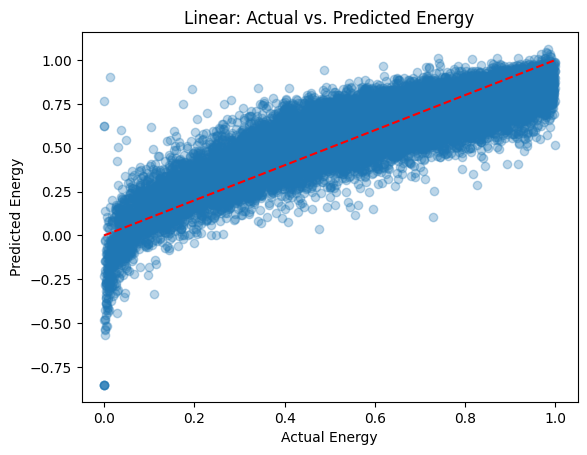

In [98]:
import matplotlib.pyplot as plt

# Get the predicted energy values using the linear_model
y_pred = linear_model.predict(test_data)


# Create a scatter plot of the actual vs. predicted energy values
plt.scatter(test_data['energy'], y_pred, alpha=0.3)
plt.xlabel('Actual Energy')
plt.ylabel('Predicted Energy')

plt.plot([min(test_data['energy']), max(test_data['energy'])],
         [min(test_data['energy']), max(test_data['energy'])],
         color='red', linestyle='--')

plt.title('Linear: Actual vs. Predicted Energy')
plt.show()


#### Interactions:

I took an exaustive approach to finding intereactions similar to what we did in the homework. There was an increase in R^2, but because of the number of predictors I am using in my model I would say this was not the greatest approach. There are extreme multicolinearity issues revealed from the VIF scores. Also because of the high number of interactions used in the model there is a very large chance that I am overfitting. Finding best interactions both in an exaustive and selective method is computationally expensive. The slight increase in R^2 is not worth finding interactions for this model.

#### Polynomial model:

There was an increase in the R^2 of the model when fitting a polynomial expression vs a linear expression. This makes sense because the most correlated features related to energy showed a polynomial curve rather then a linear one. This model beat the linear model with interactions and is far less complex reducing the risk overfitting. There is some multicolinearity issues because you have a quadratic and linear form of the same feature for each independent feature, but I do not think you can prevent this. 

It is important to review the p-values of all the features in this model to make sure they are significant. The quadratic liveness feature has a high p-value indicating that it is not statistically significant to energy.  In order to potentially improve performance and avoid misinterpretation of the results in the future I would take this feature out of the model.

When I plot the actual vs predicted values against eachother the model does seem a better fit. The regression line fits the data and doesn't level off as much towards the higher energy range of values when compared to the linear model.  There are no longer any predicted values that fall out of the actual energy range of 0 to 1 indicating a more accurate range of output values.

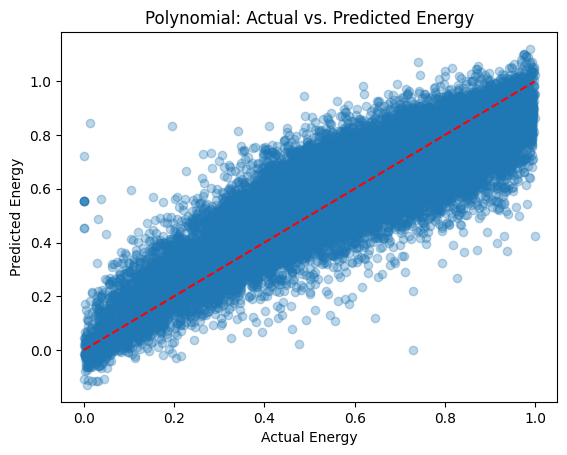

In [99]:
import matplotlib.pyplot as plt

# Get the predicted energy values using the linear_model
y_pred = poly_model.predict(test_data)


# Create a scatter plot of the actual vs. predicted energy values
plt.scatter(test_data['energy'], y_pred, alpha=0.3)
plt.xlabel('Actual Energy')
plt.ylabel('Predicted Energy')

# Add a 45-degree line representing a perfect prediction
plt.plot([min(test_data['energy']), max(test_data['energy'])],
         [min(test_data['energy']), max(test_data['energy'])],
         color='red', linestyle='--')

plt.title('Polynomial: Actual vs. Predicted Energy')
plt.show()

#### KNN:

I decided to include a non-parametric model to compare to the others. For this I used a KNN regression model. The real purpose of this was to determine if there was some other non-linear pattern in the data that I was not aware of. Because KNN does not use coefficients it can capture non-linear relationships fairly well. The R^2 of the KNN model was in fact worse then the R^2 of the polynomial model. This gives me more confidence that a second degree polynomial regression model is the best choice for this dataset.

## Citation

C.W. Chen, P. Lamere, M. Schedl, and H. Zamani. Recsys Challenge 2018: Automatic Music Playlist Continuation. In Proceedings of the 12th ACM Conference on Recommender Systems (RecSys ’18), 2018.